In [2]:
# AIR: use the mdanalysis environment

import pandas as pd
import numpy as np
import deeptime as dt
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm
import os

In [3]:


traj_list=utils.read_traj_list()

In [51]:
models = []
cthr = 15
#lagtimes = [1,10,20,30,60,100,200,300]
lagtimes = np.arange(1, 400, 20)
for lagtime in tqdm(lagtimes):
    tcm = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(traj_list)
    _ = tcm.count_matrix.copy()
    _[_<cthr] = 0
    tcm = dt.markov.TransitionCountModel(_, lagtime=lagtime)
    #counts = counts.submodel_largest(connectivity_threshold=cthr)
    #mod=dt.markov.msm.BayesianMSM(n_samples=50).fit(counts,ignore_counting_mode=True).fetch()
    mod=dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(tcm)
    models.append(mod)


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 14.88it/s]Skipping state set [194] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [194] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
 55%|█████▌    | 11/20 [00:00<00:00, 15.48it/s]Skipping state set [194] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [194] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
 65%|██████▌   | 13/20 [00:00<00:00, 15.78it/s]Skipping state set [194] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [357] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [227] due to error in estimation: Some row and corresponding column of th

In [52]:
_=dt.markov.TransitionCountEstimator(lagtime=200,count_mode='sliding').fit_fetch(traj_list)








Text(0, 0.5, 'timescale (steps)')

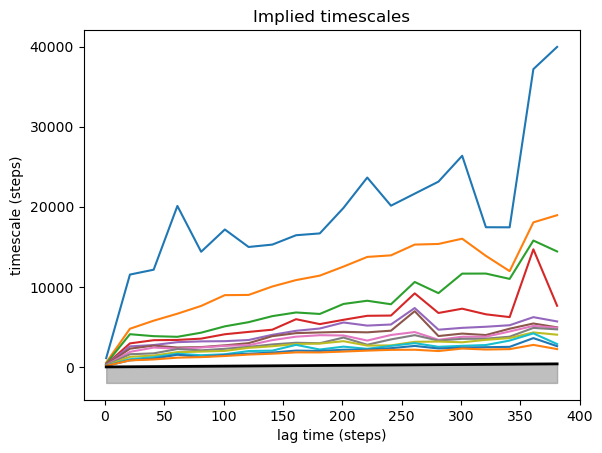

In [53]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=12, ax=ax)
#ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')



In [54]:
# Bayesian estimation (slow)

estimator = dt.markov.msm.BayesianMSM(
    n_samples=100,
    n_steps=10,
    reversible=True,
    stationary_distribution_constraint=None
)
ts_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1, count_mode="effective"
)
counts_effective = ts_estimator.fit(traj_list).fetch_model()

# PCCA

In [55]:
chosen_lagtime = 250
chosen_model_idx = utils.index_of_closest(lagtimes, chosen_lagtime)
chosen_model = models[chosen_model_idx]

print(f"Number of states: {chosen_model.n_states}")


Number of states: 395


In [56]:
n_macro=6
pcca = chosen_model.pcca(n_metastable_sets=n_macro)


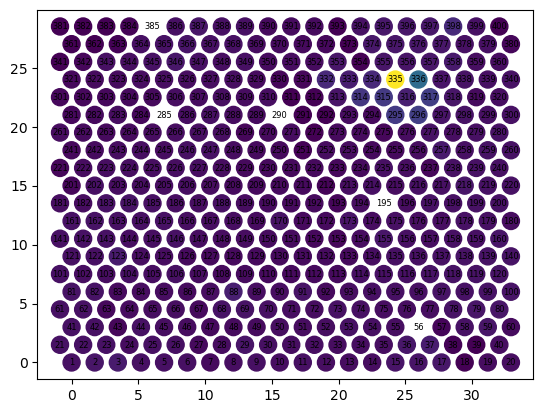

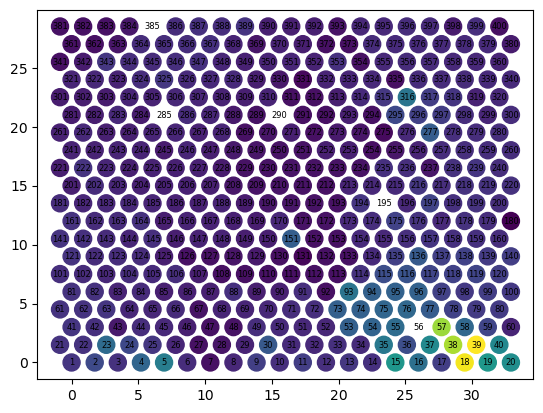

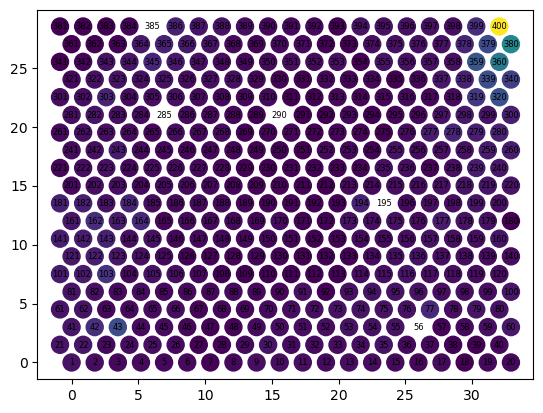

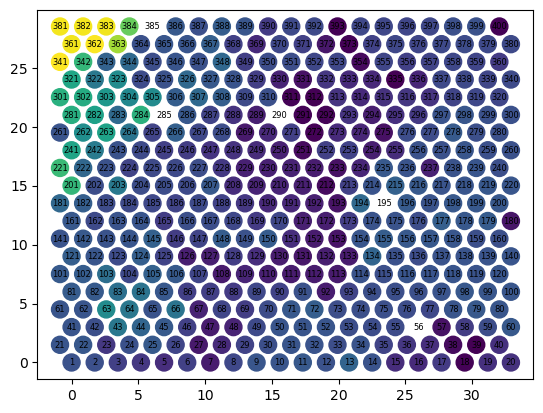

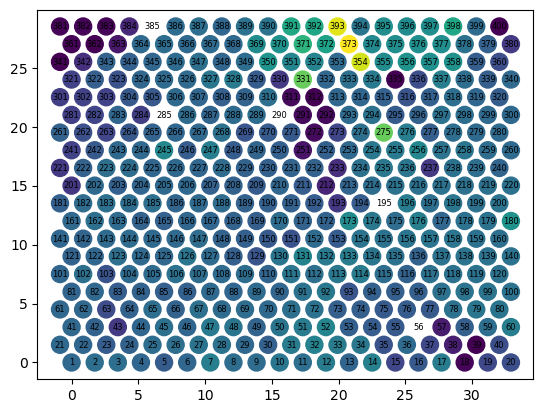

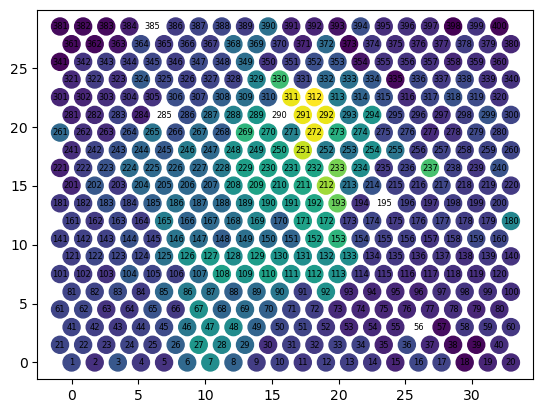

In [57]:
hgrid = utils.hexagonal_grid(20,20)
for m in range(n_macro):
    utils.state_plot(hgrid, pcca.memberships[:,m], chosen_model)
    plt.show()

[0.01483577 0.0797236  0.02501731 0.09223687 0.16467197 0.62351448]


Text(0.5, 0, 'Macrostate')

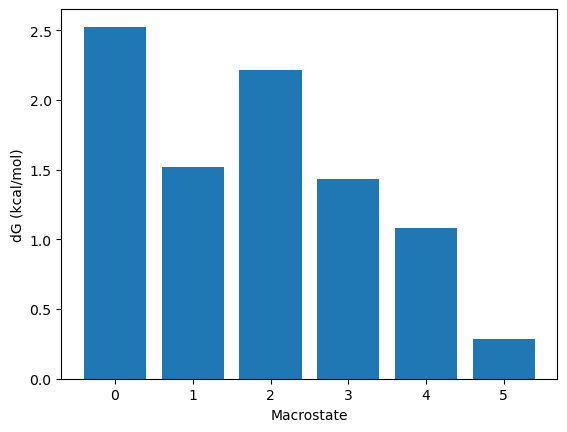

In [58]:
print(pcca.coarse_grained_stationary_probability)
plt.bar(range(n_macro),
        -.6*np.log(pcca.coarse_grained_stationary_probability))
plt.ylabel("dG (kcal/mol)")
plt.xlabel("Macrostate")

Bound state: 291 311 272

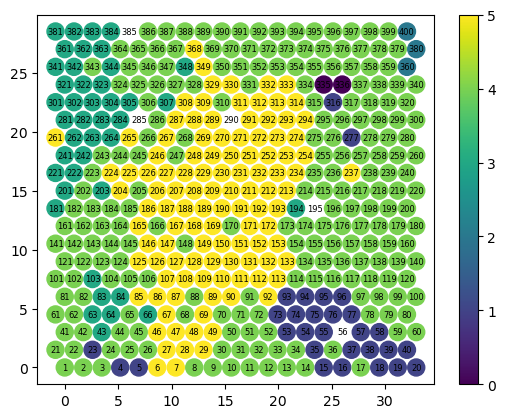

In [59]:
utils.state_plot(hgrid, pcca.assignments, chosen_model)
plt.colorbar()